## ESMACS binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the ESMACS application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Serge Guillas, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [1]:
#!pip install easysurrogate==0.24.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [3]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [4]:
%matplotlib inline
# save figures at 300 dpi
plt.rcParams['savefig.dpi'] = 300

### Load prior ranges

The JSON files below contains all default values and boundaries used for specifying the Uniform input parameter distributions. 

In [5]:
# Load the EasyVVUQ params dicts, containing the default values and type of each input
priors = {}
# there are 5 inputs files, each with a seperate params dict
prior_fnames = os.listdir('./priors')
for fname in prior_fnames:
    prior = json.load(open('./priors/%s' % fname, 'r'))
    priors = priors | prior
priors

{'d01fc': {'default': 0.75, 'type': 'float'},
 'd02fc': {'default': 0.25, 'type': 'float'},
 'd03fc': {'default': 0.092, 'type': 'float'},
 'd04fc': {'default': 0.612, 'type': 'float'},
 'd05fc': {'default': 0.252, 'type': 'float'},
 'd06fc': {'default': 0.03, 'type': 'float'},
 'd07fc': {'default': 0.154, 'type': 'float'},
 'd08fc': {'default': 0.486, 'type': 'float'},
 'd09fc': {'default': 0.033, 'type': 'float'},
 'd10fc': {'default': 1.0, 'type': 'float'},
 'd11fc': {'default': 0.45, 'type': 'float'},
 'd12fc': {'default': 0.0, 'type': 'float'},
 'd13fc': {'default': 0.53, 'type': 'float'},
 'd14fc': {'default': 0.15, 'type': 'float'},
 'd15fc': {'default': 0.5, 'type': 'float'},
 'd16fc': {'default': 1.5, 'type': 'float'},
 'd17fc': {'default': 1.05, 'type': 'float'},
 'd18fc': {'default': 10.5, 'type': 'float'},
 'd19fc': {'default': 1.1, 'type': 'float'},
 'd20fc': {'default': 1.0, 'type': 'float'},
 'box_size': {'default': 14.0, 'type': 'float'},
 'cutoff': {'default': 12.0, 't

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [6]:
# input parameters
params = pd.read_csv('./data_esmacs/esmacs_inputs.csv')
param_names = params.keys()
params = params.values

# number of code samples
n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_max = np.array([priors[name]['default'] * 1.15 for name in param_names])
p_min = np.array([priors[name]['default'] * 0.85 for name in param_names])

# except the temperature
idx_T = np.where(param_names == 'setTemperature')[0]
p_max[idx_T] = np.array(priors['setTemperature']['default'] * 1.075)
p_min[idx_T] = np.array(priors['setTemperature']['default'] * 0.925)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

### Load output samples

Load the corresponding Monte Carlo outputs, in the case the binding free energy predictions.

In [7]:
QoI = 'binding_energy'
output = pd.read_csv('./data_esmacs/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [8]:
# average the data over the replica simulations or not
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 0].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [9]:
d = 1

### Set hyperparameters

In [10]:
# number of neurons per hidden layer 
n_hidden_neurons = 20
# number of hidden layer + output layer
n_layers = 3
# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [11]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [12]:
n_rep = 20

### Train a deep active subspace network


In [13]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [14]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        # W_1 = das_surrogate.neural_net.layers[1].W
        # results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [15]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  662/662 samples to train the ML model
Neural net parameters
Number of layers = 3
Number of features = 167
Loss function = squared
Number of neurons per hidden layer = 20
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'linear']
This neural network has 228 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 380.97it/s]


 loss = 2.9846
Relative training error = 23.2097 %
Relative test error = 23.9998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 434.07it/s]

 loss = 0.8395


Relative training error = 22.1127 %
Relative test error = 22.8266 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.23it/s]


 loss = 0.8947
Relative training error = 20.1087 %
Relative test error = 21.9613 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.7473


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 343.96it/s]


Relative training error = 18.0069 %
Relative test error = 20.8069 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.6004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 367.82it/s]


Relative training error = 15.9180 %
Relative test error = 19.4079 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.6601


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 380.96it/s]


Relative training error = 13.8847 %
Relative test error = 17.6012 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.3199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 390.57it/s]


Relative training error = 12.3372 %
Relative test error = 15.7257 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1676


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 334.21it/s]


Relative training error = 11.2397 %
Relative test error = 14.1678 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1591


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 378.81it/s]


Relative training error = 10.3824 %
Relative test error = 12.6516 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 332.06it/s]


Relative training error = 9.7671 %
Relative test error = 11.9260 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 362.85it/s]


Relative training error = 9.3184 %
Relative test error = 11.3323 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 392.89it/s]


Relative training error = 9.0346 %
Relative test error = 10.7859 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 349.64it/s]


Relative training error = 8.7302 %
Relative test error = 10.1712 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 425.92it/s]


Relative training error = 8.5528 %
Relative test error = 10.0350 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 421.18it/s]

 loss = 0.0792


Relative training error = 8.4769 %
Relative test error = 9.7846 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.64it/s]


 loss = 0.1389
Relative training error = 8.4063 %
Relative test error = 9.8828 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.27it/s]

 loss = 0.1372


Relative training error = 8.3610 %
Relative test error = 9.5911 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.06it/s]


 loss = 0.1822
Relative training error = 8.2685 %
Relative test error = 9.8296 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.26it/s]

 loss = 0.0592


Relative training error = 8.2706 %
Relative test error = 9.7907 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.12it/s]

 loss = 0.1134


Relative training error = 8.2702 %
Relative test error = 9.9233 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 353.17it/s]

 loss = 0.0981


Relative training error = 8.2380 %
Relative test error = 9.6763 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.7915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 322.04it/s]


Relative training error = 22.9202 %
Relative test error = 22.0812 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.0130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 399.50it/s]


Relative training error = 21.0507 %
Relative test error = 20.6274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.88it/s]

 loss = 0.6081


Relative training error = 17.2234 %
Relative test error = 17.1274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 429.37it/s]

 loss = 0.3669


Relative training error = 13.6856 %
Relative test error = 14.6617 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 457.93it/s]

 loss = 0.3231


Relative training error = 11.5880 %
Relative test error = 12.4178 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 315.64it/s]

 loss = 0.2527


Relative training error = 10.1393 %
Relative test error = 11.1241 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1645


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 332.72it/s]


Relative training error = 9.4149 %
Relative test error = 10.4292 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2282


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 352.96it/s]


Relative training error = 8.8353 %
Relative test error = 9.6154 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 323.36it/s]


Relative training error = 8.5370 %
Relative test error = 9.3794 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1432


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 332.83it/s]


Relative training error = 8.4306 %
Relative test error = 9.2845 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 338.86it/s]


Relative training error = 8.3344 %
Relative test error = 9.0928 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 342.05it/s]


Relative training error = 8.2812 %
Relative test error = 9.7433 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1143


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 337.35it/s]


Relative training error = 8.2328 %
Relative test error = 9.6475 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1357


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 316.39it/s]


Relative training error = 8.1621 %
Relative test error = 9.6727 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 391.67it/s]


Relative training error = 8.1167 %
Relative test error = 9.7729 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.44it/s]

 loss = 1.3773


Relative training error = 23.2565 %
Relative test error = 22.9413 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 406.36it/s]

 loss = 0.6589


Relative training error = 21.9628 %
Relative test error = 22.5993 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 406.00it/s]

 loss = 0.8945


Relative training error = 19.5609 %
Relative test error = 22.1415 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.7517


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 404.04it/s]


Relative training error = 17.0017 %
Relative test error = 20.5399 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 425.51it/s]

 loss = 0.4655


Relative training error = 14.5132 %
Relative test error = 18.3266 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 423.77it/s]

 loss = 0.5258


Relative training error = 12.4677 %
Relative test error = 15.7618 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 259.64it/s]


Relative training error = 11.0276 %
Relative test error = 13.2919 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2733


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 344.98it/s]


Relative training error = 9.9657 %
Relative test error = 11.5277 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 402.79it/s]

 loss = 0.3193


Relative training error = 9.3066 %
Relative test error = 11.1053 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 426.49it/s]

 loss = 0.2157


Relative training error = 8.9623 %
Relative test error = 10.8573 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 342.78it/s]


Relative training error = 8.6914 %
Relative test error = 10.4432 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 199.86it/s]


Relative training error = 8.5141 %
Relative test error = 10.2533 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 326.13it/s]


 loss = 0.0991
Relative training error = 8.4174 %
Relative test error = 10.2743 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 309.44it/s]


 loss = 0.1685
Relative training error = 8.3603 %
Relative test error = 10.0373 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1411


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 289.48it/s]


Relative training error = 8.2477 %
Relative test error = 9.5526 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 308.63it/s]


Relative training error = 8.2035 %
Relative test error = 9.6246 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0838


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 359.04it/s]


Relative training error = 8.1750 %
Relative test error = 9.7732 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 395.72it/s]


Relative training error = 8.1477 %
Relative test error = 9.9976 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 381.44it/s]


Relative training error = 8.1744 %
Relative test error = 10.2068 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 2.2137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 315.90it/s]


Relative training error = 22.8985 %
Relative test error = 22.4135 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 404.89it/s]


 loss = 0.7356
Relative training error = 19.0575 %
Relative test error = 21.3852 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.5577


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 344.39it/s]


Relative training error = 14.8207 %
Relative test error = 17.6679 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2356


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 379.11it/s]


Relative training error = 11.8781 %
Relative test error = 14.5390 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.47it/s]


Relative training error = 10.2880 %
Relative test error = 12.3046 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2258


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.96it/s]


Relative training error = 9.3665 %
Relative test error = 11.1374 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 454.53it/s]

 loss = 0.1926


Relative training error = 9.0173 %
Relative test error = 10.9735 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.19it/s]

 loss = 0.1362


Relative training error = 8.7641 %
Relative test error = 10.6302 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 422.53it/s]

 loss = 0.1006


Relative training error = 8.5142 %
Relative test error = 10.2767 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.08it/s]

 loss = 0.1110


Relative training error = 8.4088 %
Relative test error = 9.9496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 417.49it/s]

 loss = 0.1454


Relative training error = 8.3461 %
Relative test error = 9.4863 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1487


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 460.79it/s]


Relative training error = 8.3126 %
Relative test error = 9.7939 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1357


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 360.00it/s]


Relative training error = 8.3258 %
Relative test error = 9.5058 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 379.37it/s]


Relative training error = 8.2559 %
Relative test error = 9.8996 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1094


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 360.99it/s]


Relative training error = 8.2375 %
Relative test error = 9.8064 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 392.85it/s]


Relative training error = 8.2064 %
Relative test error = 9.8336 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 331.82it/s]


Relative training error = 8.1519 %
Relative test error = 9.7439 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 406.97it/s]

 loss = 0.8460


Relative training error = 22.5075 %
Relative test error = 22.3806 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.8444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 314.11it/s]


Relative training error = 18.5191 %
Relative test error = 20.4782 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.6916


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 246.36it/s]


Relative training error = 15.0733 %
Relative test error = 18.1052 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.5210


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 362.13it/s]


Relative training error = 12.3138 %
Relative test error = 15.7446 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2925


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 298.57it/s]


Relative training error = 10.7086 %
Relative test error = 13.3723 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1832


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.54it/s]


Relative training error = 9.6934 %
Relative test error = 12.3595 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 335.01it/s]


Relative training error = 9.1884 %
Relative test error = 11.7643 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1717


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 334.80it/s]


Relative training error = 8.8259 %
Relative test error = 10.5988 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0956


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 357.28it/s]


Relative training error = 8.5195 %
Relative test error = 10.3535 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 315.17it/s]


Relative training error = 8.3861 %
Relative test error = 10.2523 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0838


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 325.88it/s]


Relative training error = 8.2707 %
Relative test error = 10.1437 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 394.35it/s]


Relative training error = 8.1906 %
Relative test error = 9.6054 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 372.74it/s]


Relative training error = 8.1695 %
Relative test error = 10.0508 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1099


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 382.25it/s]


Relative training error = 8.1301 %
Relative test error = 10.1879 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 494.71it/s]

 loss = 0.0827


Relative training error = 8.1143 %
Relative test error = 10.0218 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 544.16it/s]

 loss = 0.1199


Relative training error = 8.1292 %
Relative test error = 9.7423 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 539.10it/s]


 loss = 0.0752
Relative training error = 8.0887 %
Relative test error = 9.4548 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 342.33it/s]

 loss = 0.1108


Relative training error = 8.0645 %
Relative test error = 9.5853 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1035


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.93it/s]


Relative training error = 8.0665 %
Relative test error = 9.7793 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 395.06it/s]


Relative training error = 8.0450 %
Relative test error = 9.8405 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 408.95it/s]

 loss = 0.1464


Relative training error = 8.0140 %
Relative test error = 9.7632 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 2.5465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.90it/s]


Relative training error = 22.9297 %
Relative test error = 22.3812 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.1278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 472.60it/s]


Relative training error = 21.7343 %
Relative test error = 22.4085 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.34it/s]


 loss = 1.0687
Relative training error = 20.3111 %
Relative test error = 22.0714 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.07it/s]

 loss = 0.4987


Relative training error = 18.7072 %
Relative test error = 22.0175 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 521.57it/s]


 loss = 0.5199
Relative training error = 16.7544 %
Relative test error = 20.6959 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 426.16it/s]

 loss = 0.3812


Relative training error = 15.0901 %
Relative test error = 19.2638 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.76it/s]

 loss = 0.2943


Relative training error = 13.7073 %
Relative test error = 17.6192 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 423.51it/s]

 loss = 0.3450


Relative training error = 12.5832 %
Relative test error = 15.5979 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 394.20it/s]

 loss = 0.4429


Relative training error = 11.6987 %
Relative test error = 14.1179 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.69it/s]

 loss = 0.2243


Relative training error = 10.9411 %
Relative test error = 13.0055 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 549.96it/s]

 loss = 0.3872


Relative training error = 10.2855 %
Relative test error = 12.5029 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 451.55it/s]

 loss = 0.1772


Relative training error = 9.7373 %
Relative test error = 11.0660 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 299.81it/s]


Relative training error = 9.3139 %
Relative test error = 10.7606 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1906


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 430.49it/s]


Relative training error = 9.1615 %
Relative test error = 10.5436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 413.44it/s]

 loss = 0.1116


Relative training error = 8.7945 %
Relative test error = 10.2325 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.21it/s]

 loss = 0.1082


Relative training error = 8.6282 %
Relative test error = 9.9312 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 546.74it/s]


 loss = 0.1931
Relative training error = 8.5006 %
Relative test error = 10.0084 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.68it/s]

 loss = 0.0982


Relative training error = 8.4207 %
Relative test error = 9.8887 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 476.81it/s]

 loss = 0.1493


Relative training error = 8.3854 %
Relative test error = 9.7848 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.33it/s]

 loss = 0.1569


Relative training error = 8.3374 %
Relative test error = 9.5106 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 437.81it/s]

 loss = 0.0875


Relative training error = 8.2936 %
Relative test error = 9.3179 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 554.23it/s]

 loss = 0.1189


Relative training error = 8.2894 %
Relative test error = 9.3443 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 558.09it/s]

 loss = 0.1311
Relative training error = 8.3106 %
Relative test error = 10.0051 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 565.22it/s]

 loss = 0.0601
Relative training error = 8.2726 %


Relative test error = 9.8230 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.78it/s]


 loss = 0.2867
Relative training error = 8.2043 %
Relative test error = 9.9381 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 516.11it/s]

 loss = 0.1255


Relative training error = 8.1919 %
Relative test error = 10.1274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 550.67it/s]

 loss = 0.0865
Relative training error = 8.1924 %


Relative test error = 10.0950 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 537.18it/s]

 loss = 0.1006
Relative training error = 8.2423 %
Relative test error = 10.2517 %


Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02662707  0.00106644 -0.01827304 -0.01481842
  0.00496895 -0.0175265

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 368.32it/s]

 loss = 0.8098


Relative training error = 23.1036 %
Relative test error = 22.3705 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 518.37it/s]


 loss = 0.8654
Relative training error = 20.5577 %
Relative test error = 20.6339 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 345.88it/s]

 loss = 0.9384


Relative training error = 17.0928 %
Relative test error = 18.1894 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.5003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 479.94it/s]


Relative training error = 13.7140 %
Relative test error = 15.0018 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 375.71it/s]

 loss = 0.3830


Relative training error = 11.3927 %
Relative test error = 13.4279 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 532.93it/s]

 loss = 0.2005


Relative training error = 10.0364 %
Relative test error = 11.7688 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 431.01it/s]

 loss = 0.2857


Relative training error = 9.1821 %
Relative test error = 10.3373 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 526.48it/s]

 loss = 0.2992


Relative training error = 8.7587 %
Relative test error = 10.0882 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 424.04it/s]

 loss = 0.0993


Relative training error = 8.6269 %
Relative test error = 9.6353 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.21it/s]

 loss = 0.1378


Relative training error = 8.4759 %
Relative test error = 9.8484 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 450.21it/s]

 loss = 0.1388


Relative training error = 8.3413 %
Relative test error = 9.4693 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.32it/s]

 loss = 0.1216


Relative training error = 8.3840 %
Relative test error = 9.3602 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1309


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 335.32it/s]


Relative training error = 8.2254 %
Relative test error = 9.2102 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 316.92it/s]


Relative training error = 8.2011 %
Relative test error = 9.6023 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1499


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 329.93it/s]


Relative training error = 8.1612 %
Relative test error = 9.3687 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1275


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 414.82it/s]


Relative training error = 8.1741 %
Relative test error = 9.2848 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.69it/s]


 loss = 0.0924
Relative training error = 8.1480 %
Relative test error = 9.2097 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1190


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 339.09it/s]


Relative training error = 8.1336 %
Relative test error = 9.4695 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0871


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 432.04it/s]


Relative training error = 8.1330 %
Relative test error = 9.5821 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 435.75it/s]

 loss = 2.1174


Relative training error = 23.8634 %
Relative test error = 24.6611 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.94it/s]

 loss = 0.7387


Relative training error = 21.1452 %
Relative test error = 23.0688 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.58it/s]

 loss = 0.7004


Relative training error = 17.7623 %
Relative test error = 21.4781 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.60it/s]

 loss = 0.5733


Relative training error = 14.2803 %
Relative test error = 18.7736 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.3135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 337.53it/s]


Relative training error = 12.0629 %
Relative test error = 15.4557 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.3504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 436.05it/s]


Relative training error = 10.5605 %
Relative test error = 13.0726 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.79it/s]

 loss = 0.1426


Relative training error = 9.6875 %
Relative test error = 11.0193 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.38it/s]


 loss = 0.1968
Relative training error = 9.2606 %
Relative test error = 10.4922 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 449.56it/s]


 loss = 0.1808
Relative training error = 8.8401 %
Relative test error = 10.4250 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.84it/s]


 loss = 0.1526
Relative training error = 8.6165 %
Relative test error = 10.2534 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.05it/s]


 loss = 0.1318
Relative training error = 8.4892 %
Relative test error = 10.3458 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 459.08it/s]

 loss = 0.1092


Relative training error = 8.3617 %
Relative test error = 10.0002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 439.78it/s]

 loss = 0.1233


Relative training error = 8.3267 %
Relative test error = 10.0539 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.64it/s]

 loss = 0.1299


Relative training error = 8.2329 %
Relative test error = 9.9171 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.81it/s]

 loss = 0.0942


Relative training error = 8.2361 %
Relative test error = 9.9734 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.29it/s]

 loss = 0.1024


Relative training error = 8.2047 %
Relative test error = 10.3943 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.97it/s]

 loss = 0.0742


Relative training error = 8.1195 %
Relative test error = 10.0379 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.99it/s]


 loss = 0.1459
Relative training error = 8.1263 %
Relative test error = 10.1766 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1673


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 344.75it/s]


Relative training error = 8.0912 %
Relative test error = 9.8378 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 343.48it/s]


Relative training error = 8.1203 %
Relative test error = 9.7114 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 345.78it/s]


Relative training error = 8.1357 %
Relative test error = 9.8214 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 345.98it/s]


Relative training error = 8.0491 %
Relative test error = 9.8004 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.96it/s]


Relative training error = 8.0513 %
Relative test error = 9.7447 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 458.66it/s]

 loss = 0.0693


Relative training error = 8.0364 %
Relative test error = 9.2561 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 455.55it/s]

 loss = 1.2039


Relative training error = 23.9335 %
Relative test error = 23.2312 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 538.55it/s]

 loss = 0.9520


Relative training error = 23.1025 %
Relative test error = 22.6783 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 560.64it/s]

 loss = 0.8347
Relative training error = 19.0423 %


Relative test error = 20.5576 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 585.08it/s]


 loss = 0.6124
Relative training error = 14.4462 %
Relative test error = 16.9166 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.4233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 574.32it/s]


Relative training error = 11.9023 %
Relative test error = 14.3175 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 559.63it/s]


Relative training error = 10.4662 %
Relative test error = 12.5898 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 551.17it/s]

 loss = 0.2303


Relative training error = 9.5439 %
Relative test error = 11.3978 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 544.47it/s]


 loss = 0.1281
Relative training error = 9.1164 %
Relative test error = 10.7409 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 470.56it/s]

 loss = 0.1243


Relative training error = 8.6438 %
Relative test error = 10.0004 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 562.04it/s]

 loss = 0.1910


Relative training error = 8.4762 %
Relative test error = 9.7265 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 422.86it/s]

 loss = 0.1527


Relative training error = 8.3560 %
Relative test error = 9.7871 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.75it/s]

 loss = 0.1273


Relative training error = 8.2461 %
Relative test error = 9.5695 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 448.14it/s]


 loss = 0.1502
Relative training error = 8.2543 %
Relative test error = 9.6299 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.75it/s]


 loss = 0.0790
Relative training error = 8.2271 %
Relative test error = 9.5477 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0986


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 337.95it/s]


Relative training error = 8.2305 %
Relative test error = 9.4742 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 344.19it/s]


Relative training error = 8.2106 %
Relative test error = 9.3320 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.9392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 433.50it/s]


Relative training error = 24.2846 %
Relative test error = 22.8014 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.64it/s]


 loss = 1.5547
Relative training error = 22.0402 %
Relative test error = 21.6099 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.65it/s]

 loss = 0.9724


Relative training error = 19.5526 %
Relative test error = 19.6099 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.6261


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 343.34it/s]


Relative training error = 16.2771 %
Relative test error = 18.0910 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.6981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 339.09it/s]


Relative training error = 13.4044 %
Relative test error = 15.5185 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.4371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 393.26it/s]


Relative training error = 11.2373 %
Relative test error = 12.7973 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 426.15it/s]

 loss = 0.3282


Relative training error = 9.9198 %
Relative test error = 11.4013 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 524.59it/s]

 loss = 0.2126


Relative training error = 9.3657 %
Relative test error = 10.6638 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 534.26it/s]


 loss = 0.1465
Relative training error = 9.0451 %
Relative test error = 10.1113 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 558.15it/s]

 loss = 0.0688
Relative training error = 8.7388 %


Relative test error = 9.3610 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 468.90it/s]

 loss = 0.1738


Relative training error = 8.6565 %
Relative test error = 9.6741 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 494.23it/s]

 loss = 0.1664


Relative training error = 8.4333 %
Relative test error = 9.6375 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 452.59it/s]

 loss = 0.0640


Relative training error = 8.3428 %
Relative test error = 10.0054 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.63it/s]

 loss = 0.1042


Relative training error = 8.2987 %
Relative test error = 10.2109 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 446.22it/s]

 loss = 1.0239


Relative training error = 22.5607 %
Relative test error = 22.7257 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 427.81it/s]

 loss = 0.9368


Relative training error = 20.1149 %
Relative test error = 22.0971 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 404.76it/s]

 loss = 0.8515


Relative training error = 16.8761 %
Relative test error = 18.7340 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 443.22it/s]

 loss = 0.4610


Relative training error = 14.0179 %
Relative test error = 15.1208 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2607


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 346.75it/s]


Relative training error = 12.0197 %
Relative test error = 13.2463 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 447.29it/s]


Relative training error = 10.7453 %
Relative test error = 12.2223 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 381.99it/s]

 loss = 0.2513


Relative training error = 9.8359 %
Relative test error = 11.4517 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1693


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 412.56it/s]


Relative training error = 9.3447 %
Relative test error = 11.0396 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 474.25it/s]

 loss = 0.1318


Relative training error = 8.8931 %
Relative test error = 10.2851 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 461.09it/s]

 loss = 0.1434


Relative training error = 8.7760 %
Relative test error = 10.3106 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 482.44it/s]

 loss = 0.0927


Relative training error = 8.5795 %
Relative test error = 10.2366 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 504.61it/s]

 loss = 0.1297
Relative training error = 8.4941 %
Relative test error = 10.1242 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 438.34it/s]

 loss = 0.1241


Relative training error = 8.5177 %
Relative test error = 10.3387 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 526.13it/s]


 loss = 0.0735
Relative training error = 8.4089 %
Relative test error = 9.8725 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 453.47it/s]


 loss = 0.1146
Relative training error = 8.3127 %
Relative test error = 9.7478 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 506.58it/s]


 loss = 0.1304
Relative training error = 8.3817 %
Relative test error = 9.5882 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 472.86it/s]


 loss = 0.0965
Relative training error = 8.3135 %
Relative test error = 9.6108 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.22it/s]


Relative training error = 8.3246 %
Relative test error = 9.7452 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 269.52it/s]

Relative training error = 8.2918 %


Relative test error = 9.2086 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1041


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 397.18it/s]


Relative training error = 8.3066 %
Relative test error = 9.6185 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1269


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 221.17it/s]


Relative training error = 8.2302 %
Relative test error = 9.3155 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 166.43it/s]

 loss = 0.0777


Relative training error = 8.1572 %
Relative test error = 9.3663 %


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 14/23 [00:00<00:00, 131.62it/s]

 loss = 0.0898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 120.77it/s]


Relative training error = 8.1465 %
Relative test error = 9.7928 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 143.38it/s]

 loss = 0.0845


Relative training error = 8.1074 %
Relative test error = 10.1294 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 209.31it/s]

 loss = 0.1100


Relative training error = 8.1034 %
Relative test error = 10.1316 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 309.85it/s]

 loss = 1.3840


Relative training error = 23.8118 %
Relative test error = 22.7683 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.9710


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.88it/s]


Relative training error = 22.6781 %
Relative test error = 22.6328 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.5650


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 348.87it/s]


Relative training error = 20.1012 %
Relative test error = 21.0265 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.7314


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 414.02it/s]


Relative training error = 16.6670 %
Relative test error = 18.7232 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.3880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 173.89it/s]


Relative training error = 14.0457 %
Relative test error = 16.4007 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 195.47it/s]

 loss = 0.2357


Relative training error = 11.8667 %
Relative test error = 13.7638 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 235.44it/s]

 loss = 0.2981


Relative training error = 10.7689 %
Relative test error = 12.2716 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 268.36it/s]

 loss = 0.2602
Relative training error = 9.8084 %


Relative test error = 11.1070 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 260.65it/s]

 loss = 0.2975
Relative training error = 9.2232 %


Relative test error = 10.4665 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 213.33it/s]

 loss = 0.1832


Relative training error = 8.7969 %
Relative test error = 10.0525 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 198.03it/s]

 loss = 0.1587


Relative training error = 8.5801 %
Relative test error = 9.9934 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 305.15it/s]


 loss = 0.1779
Relative training error = 8.4280 %
Relative test error = 9.9410 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 418.34it/s]


Relative training error = 8.3139 %
Relative test error = 9.8626 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 341.18it/s]


 loss = 0.0985
Relative training error = 8.3209 %
Relative test error = 9.6758 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.6995


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 285.81it/s]


Relative training error = 24.7033 %
Relative test error = 25.2049 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.9558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 301.54it/s]


Relative training error = 22.9968 %
Relative test error = 23.9009 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.9969


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 291.88it/s]


Relative training error = 22.5917 %
Relative test error = 24.3158 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.9281


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 309.51it/s]


Relative training error = 22.1630 %
Relative test error = 25.0619 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.4064


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 265.82it/s]


Relative training error = 21.5642 %
Relative test error = 25.3156 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.0959


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 282.93it/s]


Relative training error = 21.2409 %
Relative test error = 24.7743 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.6146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 313.88it/s]


Relative training error = 23.3139 %
Relative test error = 22.4500 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.7719


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 236.57it/s]


Relative training error = 19.9001 %
Relative test error = 21.3570 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 207.98it/s]

 loss = 0.7393


Relative training error = 16.1237 %
Relative test error = 19.4614 %


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                      | 9/23 [00:00<00:00, 81.41it/s]

 loss = 0.2587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 115.73it/s]


Relative training error = 13.4330 %
Relative test error = 16.1403 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 291.33it/s]


 loss = 0.3058
Relative training error = 11.5901 %
Relative test error = 13.4659 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.95it/s]


Relative training error = 10.4644 %
Relative test error = 12.4773 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 238.03it/s]


Relative training error = 9.6261 %
Relative test error = 11.3652 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 198.73it/s]

 loss = 0.1391


Relative training error = 9.2103 %
Relative test error = 10.6603 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 276.33it/s]


 loss = 0.2458
Relative training error = 8.8702 %
Relative test error = 10.2376 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1728


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 188.21it/s]


Relative training error = 8.6582 %
Relative test error = 10.2795 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 184.02it/s]

 loss = 0.0660


Relative training error = 8.4825 %
Relative test error = 9.8585 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 275.70it/s]


 loss = 0.1949
Relative training error = 8.4566 %
Relative test error = 10.1748 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0968


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 300.18it/s]


Relative training error = 8.4214 %
Relative test error = 9.6825 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0902


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 173.00it/s]


Relative training error = 8.3453 %
Relative test error = 9.8264 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 195.72it/s]

 loss = 0.1001


Relative training error = 8.3303 %
Relative test error = 9.8280 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 164.28it/s]

 loss = 0.1505


Relative training error = 8.2851 %
Relative test error = 9.7088 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 356.65it/s]


 loss = 0.0944
Relative training error = 8.2424 %
Relative test error = 9.6036 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0762


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 404.22it/s]


Relative training error = 8.2173 %
Relative test error = 9.2593 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 412.06it/s]


 loss = 0.0925
Relative training error = 8.2323 %
Relative test error = 9.3953 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 169.69it/s]


Relative training error = 8.1834 %
Relative test error = 9.5683 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 130.42it/s]

 loss = 0.0998


Relative training error = 8.2192 %
Relative test error = 9.6711 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 445.97it/s]


 loss = 0.0961
Relative training error = 8.1951 %
Relative test error = 9.8632 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.8795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 190.18it/s]


Relative training error = 22.6462 %
Relative test error = 23.0503 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 296.46it/s]


 loss = 1.4914
Relative training error = 18.4295 %
Relative test error = 19.9212 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.5826


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 247.57it/s]


Relative training error = 14.3598 %
Relative test error = 16.6059 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 202.91it/s]


Relative training error = 12.2228 %
Relative test error = 13.7900 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 291.75it/s]


 loss = 0.2311
Relative training error = 11.1002 %
Relative test error = 12.3215 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 249.74it/s]


Relative training error = 10.1463 %
Relative test error = 11.3576 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 175.91it/s]


Relative training error = 9.5268 %
Relative test error = 10.4875 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 298.34it/s]


 loss = 0.1824
Relative training error = 9.1558 %
Relative test error = 10.5684 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 188.63it/s]


Relative training error = 8.9041 %
Relative test error = 10.7371 %


 loss = 0.1597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 222.79it/s]


Relative training error = 8.6986 %
Relative test error = 10.5489 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 198.26it/s]

 loss = 0.1283


Relative training error = 8.5611 %
Relative test error = 9.9539 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 258.97it/s]


 loss = 0.1389
Relative training error = 8.4373 %
Relative test error = 9.9010 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 135.30it/s]


Relative training error = 8.3565 %
Relative test error = 10.1002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 225.31it/s]

 loss = 0.1243
Relative training error = 8.2854 %
Relative test error = 9.8281 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 152.50it/s]


 loss = 0.1010
Relative training error = 8.2274 %
Relative test error = 9.5375 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 333.91it/s]


 loss = 0.2112
Relative training error = 8.2537 %
Relative test error = 9.5553 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 295.72it/s]


Relative training error = 8.2285 %
Relative test error = 9.4751 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0720


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 244.43it/s]


Relative training error = 8.1420 %
Relative test error = 9.6325 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1203


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 205.67it/s]


Relative training error = 8.1493 %
Relative test error = 9.7446 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 328.36it/s]

 loss = 2.2344


Relative training error = 23.3795 %
Relative test error = 23.4603 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 332.08it/s]


 loss = 0.9742
Relative training error = 22.3966 %
Relative test error = 22.6349 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.4616


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 416.23it/s]


Relative training error = 20.6943 %
Relative test error = 22.0732 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 406.92it/s]


 loss = 0.8102
Relative training error = 18.7689 %
Relative test error = 20.4014 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.6066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 242.92it/s]


Relative training error = 16.6016 %
Relative test error = 19.6230 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.3243


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 321.15it/s]


Relative training error = 14.6473 %
Relative test error = 19.0491 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 292.61it/s]


Relative training error = 13.4192 %
Relative test error = 17.1299 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.3437


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 285.05it/s]


Relative training error = 12.3541 %
Relative test error = 15.4539 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 301.02it/s]


Relative training error = 11.4701 %
Relative test error = 14.1410 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2539


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 307.59it/s]


Relative training error = 10.7409 %
Relative test error = 13.3251 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 332.00it/s]


Relative training error = 10.0639 %
Relative test error = 12.5115 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1971


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 280.88it/s]


Relative training error = 9.6999 %
Relative test error = 11.9635 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 297.28it/s]


 loss = 0.1156
Relative training error = 9.3205 %
Relative test error = 11.7456 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 216.71it/s]


Relative training error = 9.0862 %
Relative test error = 11.3270 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 172.11it/s]


Relative training error = 8.8939 %
Relative test error = 11.2321 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 283.54it/s]


 loss = 0.1505
Relative training error = 8.7548 %
Relative test error = 11.1334 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1469


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 276.46it/s]


Relative training error = 8.6332 %
Relative test error = 10.8949 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1509


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 258.17it/s]


Relative training error = 8.5528 %
Relative test error = 10.6390 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 242.79it/s]


Relative training error = 8.5581 %
Relative test error = 10.6606 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 211.40it/s]


Relative training error = 8.5128 %
Relative test error = 10.1736 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 165.03it/s]

 loss = 0.1320


Relative training error = 8.3509 %
Relative test error = 9.8877 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 185.51it/s]

 loss = 0.1158


Relative training error = 8.3217 %
Relative test error = 10.2289 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 265.52it/s]


 loss = 0.1162
Relative training error = 8.2946 %
Relative test error = 10.3401 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0921


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 200.09it/s]


Relative training error = 8.3051 %
Relative test error = 10.3346 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 197.11it/s]

 loss = 0.1140


Relative training error = 8.2666 %
Relative test error = 10.0887 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.03it/s]

 loss = 2.4650


Relative training error = 23.6551 %
Relative test error = 22.8684 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.8286


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 243.94it/s]


Relative training error = 20.7583 %
Relative test error = 21.7211 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.9789


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 291.52it/s]


Relative training error = 17.4539 %
Relative test error = 19.4005 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.5215


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 237.53it/s]


Relative training error = 14.6413 %
Relative test error = 17.1907 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.4045


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 174.81it/s]


Relative training error = 12.4219 %
Relative test error = 14.5838 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 222.00it/s]


 loss = 0.2527
Relative training error = 11.0309 %
Relative test error = 12.8557 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 477.38it/s]


Relative training error = 10.0257 %
Relative test error = 11.8054 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 243.23it/s]


Relative training error = 9.4617 %
Relative test error = 11.0306 %


 loss = 0.2010


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 191.58it/s]


Relative training error = 8.9791 %
Relative test error = 10.9751 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 195.58it/s]

 loss = 0.1249


Relative training error = 8.6940 %
Relative test error = 10.4750 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 221.86it/s]

 loss = 0.1191


Relative training error = 8.5320 %
Relative test error = 10.1009 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 322.05it/s]

 loss = 0.0606
Relative training error = 8.3571 %


Relative test error = 10.1888 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1375


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 296.94it/s]


Relative training error = 8.2683 %
Relative test error = 10.0581 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 301.11it/s]


Relative training error = 8.2645 %
Relative test error = 9.9843 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 210.73it/s]


Relative training error = 8.2237 %
Relative test error = 9.6266 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1234


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 359.13it/s]


Relative training error = 8.2385 %
Relative test error = 9.3474 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 294.98it/s]


Relative training error = 8.1959 %
Relative test error = 9.2070 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0895


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 280.59it/s]


Relative training error = 8.1431 %
Relative test error = 9.2509 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 203.23it/s]

 loss = 0.1337
Relative training error = 8.1183 %


Relative test error = 9.4935 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 286.26it/s]


Relative training error = 8.2202 %
Relative test error = 9.4172 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 348.70it/s]


Relative training error = 8.1195 %
Relative test error = 9.4573 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

 43%|████████████████████████████████████████████████████████████████████████▌                                                                                              | 10/23 [00:00<00:00, 92.13it/s]

 loss = 2.6813


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 103.83it/s]


Relative training error = 23.3601 %
Relative test error = 22.1619 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 163.96it/s]

 loss = 0.9876


Relative training error = 18.0955 %
Relative test error = 20.4202 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 149.96it/s]

 loss = 0.6038


Relative training error = 14.3543 %
Relative test error = 17.9330 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 281.39it/s]

 loss = 0.3022


Relative training error = 12.0144 %
Relative test error = 15.3822 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 156.32it/s]

 loss = 0.2748


Relative training error = 10.4349 %
Relative test error = 13.4495 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 248.93it/s]


 loss = 0.1669
Relative training error = 9.5367 %
Relative test error = 11.7761 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 266.53it/s]


Relative training error = 8.9365 %
Relative test error = 10.5979 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1224


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 241.12it/s]


Relative training error = 8.6447 %
Relative test error = 10.1731 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 211.62it/s]

Relative training error = 8.5059 %


Relative test error = 9.7148 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 252.36it/s]


 loss = 0.1180
Relative training error = 8.4303 %
Relative test error = 9.9359 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 143.94it/s]


 loss = 0.1244
Relative training error = 8.3162 %
Relative test error = 9.9777 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 184.14it/s]

 loss = 0.0910


Relative training error = 8.2975 %
Relative test error = 9.5233 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 160.61it/s]

 loss = 0.1361


Relative training error = 8.1979 %
Relative test error = 9.6801 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 263.79it/s]

 loss = 0.1483
Relative training error = 8.2809 %


Relative test error = 10.2246 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0795


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 253.16it/s]


Relative training error = 8.2002 %
Relative test error = 9.9958 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 223.51it/s]


Relative training error = 8.1425 %
Relative test error = 9.7127 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 156.50it/s]

 loss = 0.1601


Relative training error = 8.1177 %
Relative test error = 9.8842 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 207.67it/s]

 loss = 0.1023


Relative training error = 8.0772 %
Relative test error = 9.8554 %


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 13/23 [00:00<00:00, 115.63it/s]

 loss = 0.1624


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 121.57it/s]


Relative training error = 8.1524 %
Relative test error = 10.0450 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 191.61it/s]

 loss = 0.1483


Relative training error = 8.0975 %
Relative test error = 9.9670 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 1.8915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 165.14it/s]


Relative training error = 23.2012 %
Relative test error = 22.4976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 217.58it/s]

 loss = 0.9309


Relative training error = 22.7446 %
Relative test error = 22.0250 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 157.78it/s]

 loss = 1.1453


Relative training error = 21.0613 %
Relative test error = 21.0534 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 254.89it/s]

 loss = 0.8881


Relative training error = 18.8371 %
Relative test error = 19.1790 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 149.82it/s]

 loss = 0.3487


Relative training error = 16.7816 %
Relative test error = 17.9260 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 135.44it/s]

 loss = 0.6033


Relative training error = 15.1211 %
Relative test error = 16.5674 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 284.57it/s]

 loss = 0.3438
Relative training error = 13.7023 %


Relative test error = 15.1727 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 267.05it/s]

 loss = 0.2781


Relative training error = 12.5637 %
Relative test error = 14.0322 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 248.82it/s]

 loss = 0.2941


Relative training error = 11.5281 %
Relative test error = 12.6970 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 246.69it/s]

 loss = 0.1595


Relative training error = 10.7397 %
Relative test error = 11.9708 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 216.96it/s]

 loss = 0.1630


Relative training error = 10.0836 %
Relative test error = 11.3625 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 350.38it/s]

 loss = 0.1434


Relative training error = 9.6695 %
Relative test error = 11.2213 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 338.73it/s]


 loss = 0.1357
Relative training error = 9.2329 %
Relative test error = 10.8469 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 151.48it/s]


Relative training error = 8.9417 %
Relative test error = 10.7062 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 335.92it/s]


 loss = 0.0916
Relative training error = 8.7446 %
Relative test error = 10.2370 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 301.67it/s]


 loss = 0.0652
Relative training error = 8.5953 %
Relative test error = 9.9107 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0661


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 241.73it/s]


Relative training error = 8.5889 %
Relative test error = 9.6037 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 242.16it/s]


Relative training error = 8.4913 %
Relative test error = 10.0101 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.0866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 100.01it/s]


Relative training error = 8.5025 %
Relative test error = 9.8078 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 414.84it/s]


 loss = 0.1148
Relative training error = 8.4232 %
Relative test error = 9.8023 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.2233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 239.14it/s]


Relative training error = 8.4339 %
Relative test error = 9.7202 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 241.63it/s]


 loss = 0.1103
Relative training error = 8.3726 %
Relative test error = 9.5846 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 209.58it/s]


Relative training error = 8.3643 %
Relative test error = 9.8363 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 230.57it/s]


 loss = 0.1240
Relative training error = 8.2874 %
Relative test error = 9.5804 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 174.25it/s]

 loss = 0.0944


Relative training error = 8.3019 %
Relative test error = 9.6060 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 264.27it/s]

 loss = 0.1022


Relative training error = 8.2957 %
Relative test error = 10.0941 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 253.80it/s]

 loss = 0.1458


Relative training error = 8.2717 %
Relative test error = 10.1066 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 157.44it/s]

 loss = 0.1304


Relative training error = 8.2632 %
Relative test error = 9.7976 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.02

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 161.49it/s]

 loss = 1.8820


Relative training error = 24.5992 %
Relative test error = 23.1157 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 167.04it/s]

 loss = 0.8353


Relative training error = 23.7012 %
Relative test error = 23.2702 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 175.00it/s]

 loss = 0.9050


Relative training error = 23.4117 %
Relative test error = 22.9480 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 146.38it/s]

 loss = 0.8849


Relative training error = 22.7039 %
Relative test error = 22.1440 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 191.08it/s]

 loss = 0.7616


Relative training error = 21.1174 %
Relative test error = 20.9238 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 215.35it/s]

 loss = 0.8451


Relative training error = 18.0019 %
Relative test error = 18.7308 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 317.49it/s]


 loss = 0.6585
Relative training error = 14.3199 %
Relative test error = 16.7995 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.4133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 294.83it/s]


Relative training error = 11.9827 %
Relative test error = 15.2394 %


 57%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 13/23 [00:00<00:00, 122.72it/s]

 loss = 0.2891


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 127.08it/s]


Relative training error = 10.4623 %
Relative test error = 13.1356 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 180.35it/s]

 loss = 0.1227


Relative training error = 9.6358 %
Relative test error = 11.7968 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 230.03it/s]

 loss = 0.1272
Relative training error = 9.0846 %


Relative test error = 11.0559 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1428


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 182.88it/s]


Relative training error = 8.8005 %
Relative test error = 10.4860 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 272.17it/s]

 loss = 0.1184
Relative training error = 8.6025 %


Relative test error = 10.6730 %


  0%|                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

 loss = 0.1221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 162.53it/s]


Relative training error = 8.5121 %
Relative test error = 10.6618 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 178.61it/s]

 loss = 0.1537


Relative training error = 8.3932 %
Relative test error = 10.7580 %


 48%|███████████████████████████████████████████████████████████████████████████████▍                                                                                      | 11/23 [00:00<00:00, 105.66it/s]

 loss = 0.0804


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 124.18it/s]


Relative training error = 8.4038 %
Relative test error = 10.6313 %
Creating DAS_analysis object
[-0.01079496 -0.00636261 -0.00472965  0.00829344 -0.03315033  0.01000517
 -0.03147244  0.01236407 -0.02684816  0.00736422 -0.01663265 -0.00670413
  0.01756466 -0.01872044  0.02313004 -0.03355007  0.0332702  -0.02308934
 -0.04141354  0.01600002 -0.00833672  0.01130101  0.00841153  0.0035773
  0.00450807  0.03616873  0.00554306  0.01251749 -0.00332135  0.01660203
  0.00364524 -0.00423356 -0.01502233  0.00553334  0.00909886  0.03581746
 -0.01612826 -0.01689578 -0.00544872 -0.0257047  -0.0020281  -0.00491286
 -0.01851041 -0.00295021 -0.01707543  0.01278958 -0.03309115 -0.03378421
  0.02105434 -0.024914    0.01355151  0.0347159   0.00949286 -0.01157946
 -0.02779381  0.01103345  0.05014661 -0.0388591   0.03466138 -0.03282935
  0.01334391 -0.02446218  0.00617272  0.02966007 -0.0113076  -0.02121396
 -0.02654688 -0.02603522  0.00742446  0.0033779  -0.03955923 -0.02515224
 -0.00983606 -0.03146489 -0.0

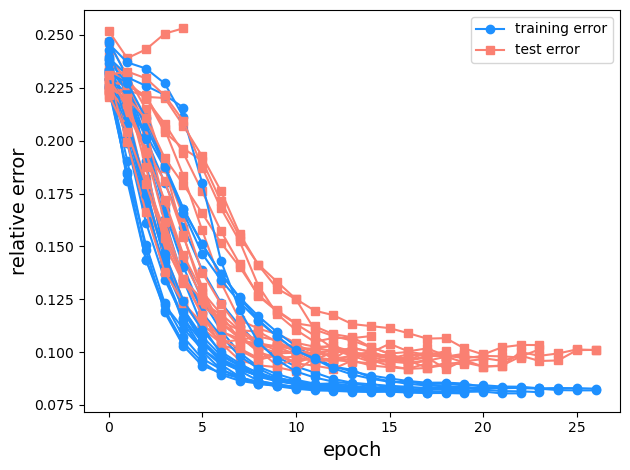

In [16]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [17]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


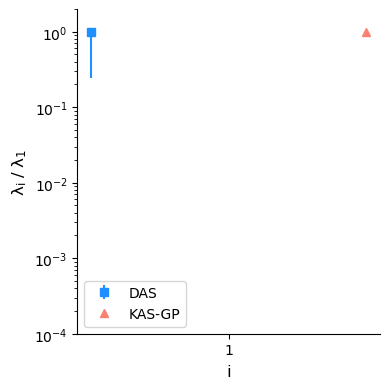

In [18]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_esmacs.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/esmacs_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [19]:
# run the surrogate at a number of random inputs locations drawn from U[-1, 1]
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])

In [20]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

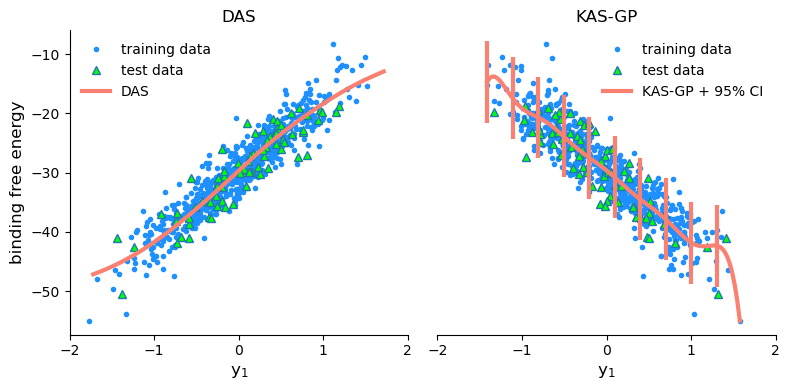

In [21]:
# QoI labels
lbl = {QoI: r'binding free energy'}

# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/esmacs_result.npy', allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/esmacs_surrogate_d%d.png' % (d, ))

### Recreate the global-derivative based sensitivity plots

In [22]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_esmacs.csv')

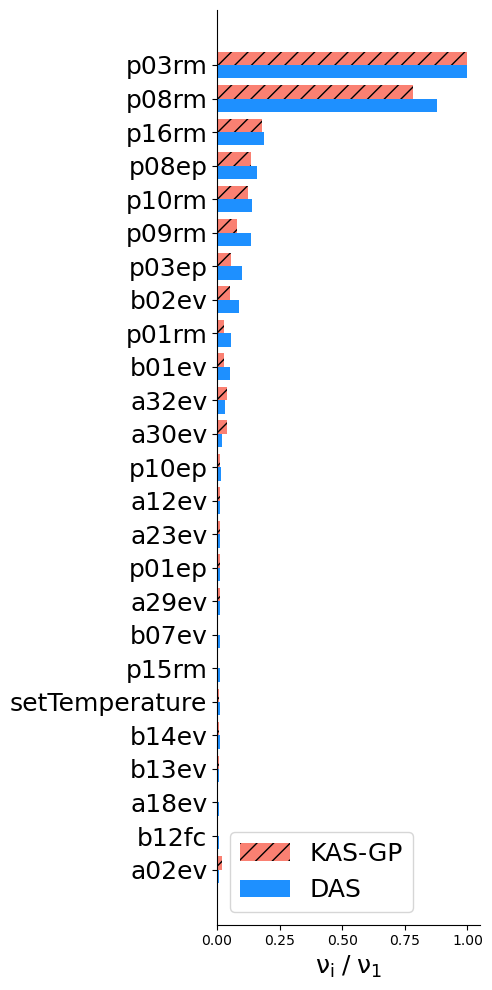

In [23]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


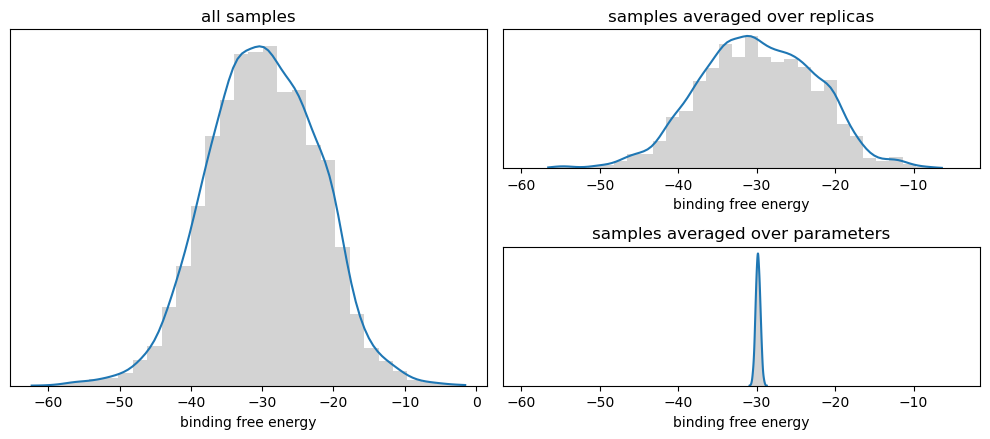

In [24]:
plot_dist(output, 'binding free energy')

### (Non-Gaussian) stats with bootstrapping

In [25]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:15<00:00, 390.74it/s]


In [26]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [27]:
print("Mean: %.2e (%.2e/%.2e)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2e (%.2e/%.2e)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.3f/%.3f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: -2.99e+01 (-2.99e+01/-2.98e+01)
Std dev: 7.68e+00 (7.61e+00/7.74e+00)
Skew: -0.08 (-0.117/-0.050)
Kurt: 0.07 (0.00/0.14)
N_samples = 18400
